In [4]:
import pandas as pd
import os
from glob import glob
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

## load  channel name and cell type info

<!-- 	ON	ON/OFF	OFF	Unknown	Sum
count	32	10	13	52	107 -->


In [5]:
dataset = '20201216'
# dataset = '20201209'

data_path = os.path.join('data', dataset)

In [6]:
# read the csv file
info = pd.read_csv(os.path.join(data_path, 'cell_type.csv'))

info.replace('-', 'Unknown', inplace=True)

info

,channel,cell_type
0,12a,OFF
1,12b,ON
2,13a,Unknown
3,13b,Unknown
4,13c,OFF
...,...,...
102,86a,ON
103,86b,ON
104,86c,ON
105,87a,ON-OFF


In [7]:
info['cell_type'].value_counts() / len(info)

Unknown    0.485981
ON         0.299065
OFF        0.121495
ON-OFF     0.093458
Name: cell_type, dtype: float64

## load stim

In [8]:
stim_info_path = glob(os.path.join(data_path,'StimInfo*.mat'))[0]
stim_info_path

'data/20201216/StimInfo_13pix_132um_30Hz.mat'

In [9]:
# read stimulus
import scipy.io as sio
stim = list()
for stim_info in sio.loadmat(stim_info_path)['StimInfo']:
    stim.append(stim_info[0][0])
    # print(stim_info[0][0].shape)
stim = np.array(stim)

In [10]:
stim.shape

(27000, 169)

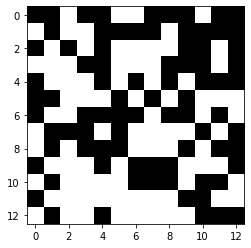

In [12]:
plt.imshow(stim[0,:].reshape(13,13), cmap='gray')

## load spike counts

In [13]:
def count_spikes(spike_times, bins, timestamp_start=0):
    num_bins = bins.shape[0]
    spike_count = np.zeros_like(bins)
    for i in range(num_bins):
        if i == 0:
            continue

        spike_count[i] = np.sum(np.logical_and(spike_times >= timestamp_start + bins[i-1], spike_times < timestamp_start + bins[i]))
    return spike_count

In [23]:
# read spike counts
path = glob(os.path.join(data_path, 'SpikeTrain_'+dataset,  'SpikeTrain_*'))[0]

# load time stamps
filename = os.path.join(path, 'A1a.mat')
print(filename)
ts = sio.loadmat(filename)['A1a'].ravel()
# print(ts[0], ts[-1], ts.shape)

# load spike times
# channel_names = list()
spike_counts = list()
for i, channel_name in enumerate(tqdm(info['channel'])):
    filename = os.path.join(path, 'ch_' + channel_name)
    # print(filename)
    spike_time = sio.loadmat(filename)['ch_' + channel_name].ravel()

    # count spikes
    spike_counts.append(count_spikes(spike_time, ts))

spike_counts = np.array(spike_counts)

  0%|          | 0/107 [00:00<?, ?it/s]

data/20201216/SpikeTrain_20201216/SpikeTrain_ND2_13pix_132um_30Hz/A1a.mat


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


In [24]:
spike_counts.shape

(107, 27000)

(array([2.093589e+06, 6.220040e+05, 1.358410e+05, 2.657700e+04,
        7.690000e+03, 2.327000e+03, 7.230000e+02]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5]),
 <a list of 7 Patch objects>)

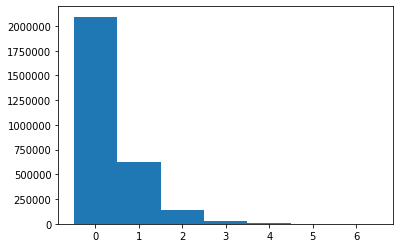

In [25]:
plt.hist(spike_counts.ravel(), [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])

## save to npz and csv

put these files under `data`

In [26]:
np.savez(dataset, dataset=dataset, stim=stim, spike_counts=spike_counts)

In [27]:
info.to_csv(dataset+'_info.csv', index=None)